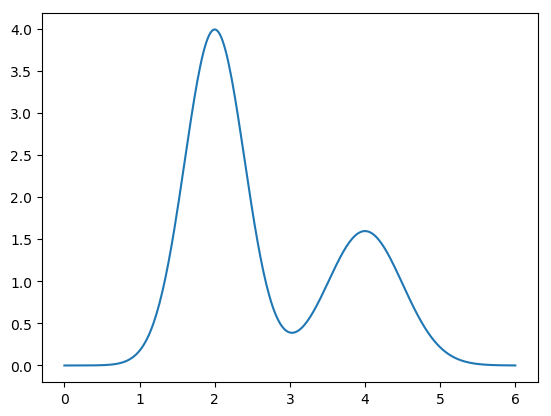

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1aa121160>

In [31]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")
include("../src/mcmc.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

import PyPlot.plot
myplot = plot(x, phi.(x))

In [32]:
kernel_name = "heaviside"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

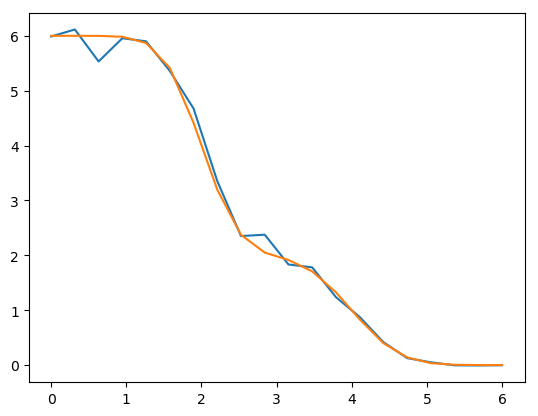

[5.99994, 5.99985, 5.99868, 5.98295, 5.86899, 5.41494, 4.41504, 3.19693, 2.37322, 2.04991, 1.91539, 1.70788, 1.32623, 0.83319, 0.399667, 0.140503, 0.0352051, 0.00613985, 0.000692657, 0.0]



In [33]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=20))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

const_sig = [-0.01261988076481369, 0.11549222383853759, -0.46621847536331, -0.027254387627552102, 0.03065511435482842, -0.05435612148005363, 0.2604677397058683, 0.1565930441161031, -0.02176112453218068, 0.3259096052065758, -0.08200256535971161, 0.07268039882059657, -0.08810335857089219, 0.043810151147082615, 0.018032974081921074, -0.01322823199373628, 0.015293716559492491, -0.010829962058481626, -0.007877576791090336, -0.0025713120114854845]

noise = const_sig
println(ftrue)
f = ftrue + noise
plot(y, f)
plot(y, ftrue)
println()

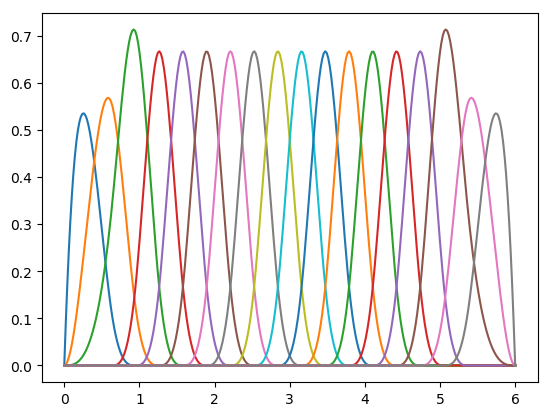

┌ Info: Cubic spline basis is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:241


In [34]:
knots = y
basis = CubicSplineBasis(knots, ("dirichlet", "dirichlet"))

for func in basis.basis_functions
    plot(x, func.f.(x))
end

In [35]:
using PyPlot

Omega = omega(basis, 2)
print()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:249
┌ Info: Omega caclulated successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:264


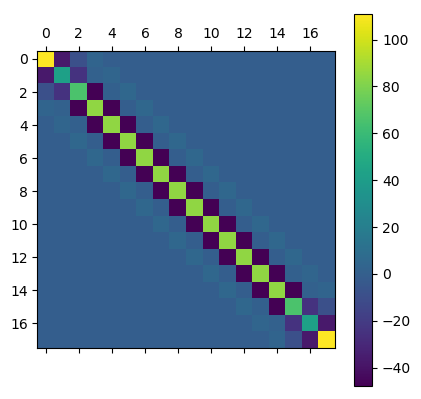

PyObject <matplotlib.colorbar.Colorbar object at 0x19b7380b8>

In [36]:
matshow(Omega)
colorbar()

In [61]:
model = GaussErrorUnfolder(basis, [Omega], "User", [0.005])#, "EmpiricalBayes", nothing, [1e-8], [10.], [0.3])
println()

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:118
┌ Info: GaussErrorUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:323


In [62]:
phi_reconstruct = solve(model, kernel, f, sig, y)

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:357
┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:51
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:62
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:385
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:149
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:179
┌ Info: Starting solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:190
┌ Info: Ending solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:276


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [1.51689 0.196872 … -2.91683e-6 -2.83396e-6; 0.196872 2.43062 … 5…
  "alphas" => [0.005]
  "coeff"  => [0.130277, 0.0426136, -0.122607, 0.75687, 2.21563, 3.43546, 3.370…

In [63]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["errors"])
println()

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


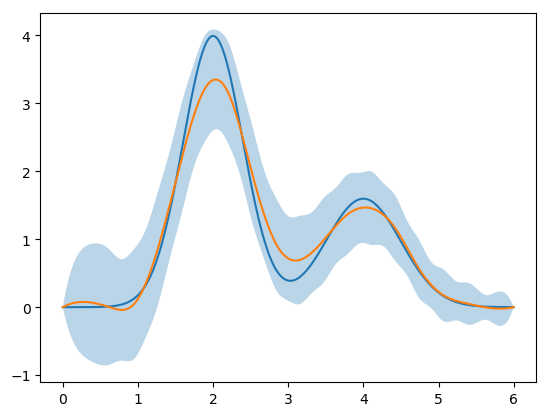

PyObject <matplotlib.collections.PolyCollection object at 0x19b723d30>

In [65]:
using PyPlot

plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)
println()

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

In [72]:
model_mcmc = MCMC_matrix([Omega], "User", [0.005])#, "EmpiricalBayes", nothing, [1e-5], [10.], [0.5])
println()

┌ Info: GaussErrorMatrixUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:90


In [73]:
model_, line, inits, samples, burnin, thin, chains = solve(model_mcmc, discretize_kernel(basis, kernel, y), f, sig, 1, 10000)
sim = mcmc(model_, line, inits, samples, burnin=burnin, thin=thin, chains=chains)
res = get_values(sim, chains, length(basis))
println()

┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:51
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:62
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:105
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:133
┌ Info: Starting solve_correct...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:147


MCMC Simulation of 10000 Iterations x 1 Chain...

Chain 1:   0% [0:00:26 of 0:00:26 remaining]
Chain 1:  10% [0:00:33 of 0:00:37 remaining]
Chain 1:  20% [0:00:32 of 0:00:40 remaining]
Chain 1:  30% [0:00:29 of 0:00:41 remaining]
Chain 1:  40% [0:00:24 of 0:00:41 remaining]
Chain 1:  50% [0:00:20 of 0:00:40 remaining]
Chain 1:  60% [0:00:16 of 0:00:39 remaining]
Chain 1:  70% [0:00:12 of 0:00:40 remaining]
Chain 1:  80% [0:00:08 of 0:00:39 remaining]
Chain 1:  90% [0:00:04 of 0:00:39 remaining]
Chain 1: 100% [0:00:00 of 0:00:39 remaining]




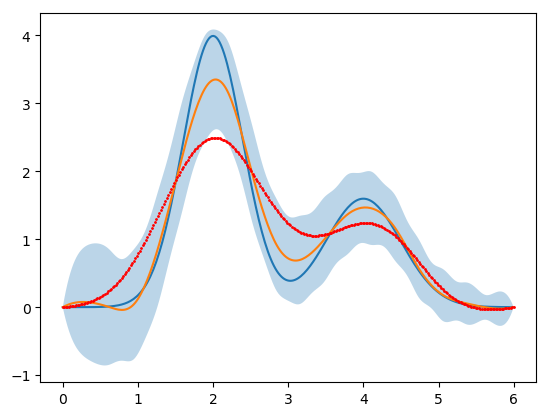

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:50


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x19bc07b70>

In [74]:
phivec_mcmc = PhiVec(res, basis)
phi_reconstructed_mcmc = phivec_mcmc.phi_function.(x)
plot(x, phi.(x))
plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
plot(x, phi_reconstructed_mcmc, "ro", markersize=1)